#### Base Settings

##### Library

In [1]:
# Library import

## pandas
import pandas as pd

import gdown
import zipfile as zf
from tqdm import tqdm
import nltk

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import string
from collections import Counter
import random

# shikit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow as keras
from keras import layers, Input, Sequential, Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, \
                                    TextVectorization
import tensorflow_datasets as tfds

##### Parmas

In [2]:
RAND_SEED = 83
random.seed(RAND_SEED)

NUM_TEXT_DATA       = 0.1         #📌 사용할 데이터 비율
MAX_LENGTH          = 20            #📌 문장 길이
BATCH_SIZE          = 64
BUFFER_SIZE         = 20000
NUM_LAYERS          = 1
D_MODEL             = 128
NUM_HEADS           = 4
DFF                 = 128
DROPOUT             = 0.2
VOCAB_SIZE          = 10000
EPOCHS              = 10

### Data handling

In [3]:
def collect_json_file(path):
    """
    폴더의 json파일을 모두 불러와 리스트로 반환하는 함수
    """
    file_list = os.listdir(path)

    json_list = []
    for file_name in file_list:
        if '.json' in file_name:
            json_list.append(file_name)

    return json_list

In [4]:
def parsing_corpus(js):
    Q1_list = [js[x]["talk"]["content"]["HS01"] for x in range(len(js))]
    Q2_list = [js[x]["talk"]["content"]["HS02"] for x in range(len(js))]
    Q3_list = [js[x]["talk"]["content"]["HS03"] for x in range(len(js))]
    A1_list = [js[x]["talk"]["content"]["SS01"] for x in range(len(js))]
    A2_list = [js[x]["talk"]["content"]["SS02"] for x in range(len(js))]
    A3_list = [js[x]["talk"]["content"]["SS03"] for x in range(len(js))]

    df_qa = pd.DataFrame({"Q1":Q1_list,"A1":A1_list,"Q2":Q2_list,"A2":A2_list,"Q3":Q3_list,"A3":A3_list})

    return df_qa

#### 감성 대화 말뭉치

- [감성 대화 말뭉치](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86)



2020년/10,000문장 (음성), 27만문장 (코퍼스)



In [5]:
# 데이터파일(.json) 불러와서 폴더에 저장

## 데이터파일 불러올 URL
url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing",
            "https://drive.google.com/file/d/1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c/view?usp=sharing"]

for idx, val in enumerate(url_list):
    data_url = val
    file_name = "donwload.zip"
    unzip_path = "data/emotion/"

    # 데이터 다운로드
    file_id = "https://drive.google.com/uc?id=" + data_url.split('/')[-2]
    gdown.download(file_id, file_name)

    # 압축풀기
    files = zf.ZipFile(file_name)
    files.extractall(unzip_path)
    files.close()

# 데이터파일(.json)
json_list = collect_json_file(unzip_path)
print(f"\n데이터파일 개수 : {len(json_list)}개")

Downloading...
From: https://drive.google.com/uc?id=1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg
To: /content/donwload.zip
100%|██████████| 8.30M/8.30M [00:00<00:00, 54.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c
To: /content/donwload.zip
100%|██████████| 993k/993k [00:00<00:00, 67.2MB/s]


데이터파일 개수 : 2개


In [6]:
with tqdm(total=len(json_list)) as pbar:
    df_concat = pd.DataFrame()
    for idx, val in enumerate(json_list):
        with open(unzip_path+json_list[idx]) as f:
            js = json.loads(f.read())
            df_qa = parsing_corpus(js)
            print(f"{idx+1}번째 파일의 크기: {df_qa.shape}")
            df_concat = pd.concat([df_concat,df_qa])
        pbar.update()

print(f"\n데이터파일의 크기(shape) : {df_concat.shape}")

 50%|█████     | 1/2 [00:00<00:00,  1.41it/s]

1번째 파일의 크기: (6640, 6)


100%|██████████| 2/2 [00:04<00:00,  2.38s/it]

2번째 파일의 크기: (51628, 6)

데이터파일의 크기(shape) : (58268, 6)


In [7]:
print(f"질문1 : {df_concat.iloc[0,0]}")
print(f"답변1 : {df_concat.iloc[0,1]}")
print(f"질문2 : {df_concat.iloc[0,2]}")
print(f"답변2 : {df_concat.iloc[0,3]}")
print(f"질문3 : {df_concat.iloc[0,4]}")
print(f"답변3 : {df_concat.iloc[0,5]}")

질문1 : 이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너무 미안해.
답변1 : 실수하시다니 정말 미안한 마음이 크겠어요.
질문2 : 내 능력이 부족한 거 같은데 그만 다녀야 될거같아.
답변2 : 능력을 올리려면 어떤 방법이 있을까요?
질문3 : 퇴근 후 여가에 회사 일을 더 열심히 해서 피해가 가지 않도록 해야겠어.
답변3 : 꼭 좋은 결과 있길 바라요.


In [8]:
df_concat.tail()

,Q1,A1,Q2,A2,Q3,A3
51623,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.,경제적인 문제 때문에 막막하시군요. 마음이 편치 않으시겠어요.,아무것도 할 수 없는 내가 무가치하게 느껴지고 실망스러워.,지금 할 수 있는 가장 합리적인 행동은 무엇인가요?,노년층을 위한 경제적 지원이나 부업 같은 것도 알아보아야겠어.,좋은 결과 얻으시길 바랄게요.
51624,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.,건강에 대한 어려움 때문에 기분이 좋지 않으시군요. 속상하시겠어요.,마음 같아서는 다 할 수 있는 일인데 이젠 몸이 안 따라와 주니 화만 나.,어떻게 하면 지금의 기분을 나아지게 할 수 있을까요?,남편과 함께 게이트볼이나 치러 가야겠어. 그럼 기분이 나아질 것 같아.,남편과 함께하는 좋은 외출 시간 되시길 바랄게요.
51625,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.,노후 준비에 대한 어려움 때문에 걱정이 많으시겠어요.,주변 사람들은 다 노후 준비도 잘해두었던데 난 어떻게 해야 할지 모르겠어. 막막하기...,지금의 상황에서 할 수 있는 가장 좋은 행동이 무엇일까요?,남편과 함께 실버 일자리나 노년층을 위한 국가 지원에 대해 자세히 알아보아야겠어.,좋은 정보 많이 얻으셔서 걱정을 좀 덜으셨으면 좋겠어요.
51626,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.,가족과의 문제 때문에 속상하시겠어요.,이제 할 수 있는 일도 없고 이렇게 힘들게 사는 게 불만스럽기만 해.,지금의 감정을 나아지게 할 수 있는 어떤 방법이 있을까요?,함께 친하게 지내던 동네 언니 동생들과 빈자리를 조금이나마 채울까 해.,지인분들과 좋은 시간 보내셨으면 좋겠어요.
51627,남편과 결혼한 지 사십 년이야. 이제 사람 만나는 것도 버겁고 알던 사람도 점점 사라져.,대인관계에 대한 어려움 때문에 걱정되시고 속상하시겠어요.,사람들을 만나는 것이 어려워. 자꾸 사람들을 의심하게만 되고 말이야.,어떻게 하면 지금의 상황에 변화를 만들어낼 수 있을까요?,사람들을 볼 때 의심하고 불신하는 마음을 억눌러야겠어. 사람들을 색안경을 끼고 보지...,원하시는 대로 가지고 계시던 걱정이 잘 해결되셨으면 좋겠어요.


In [9]:
# # 모든턴 사용
# df_1 = df_concat[["Q1","A1"]]
# df_2 = df_concat[["Q2","A2"]]
# df_3 = df_concat[["Q3","A3"]]

# df_1.columns = ["Q1", "A1"]
# df_2.columns = ["Q1", "A1"]
# df_3.columns = ["Q1", "A1"]

# df = pd.DataFrame()
# df = pd.concat([df,df_1])
# df = pd.concat([df,df_2])
# df = pd.concat([df,df_3])


# df.reset_index(drop=True, inplace=True)
# filt = df["A1"].str.len() < 3
# df.drop(index=df[filt].index, inplace=True)
# print(df.shape)
# df.sample(5)

In [10]:
# 1턴만 사용
df = df_concat[["Q1","A1"]].copy()
print(df.shape)
df.sample(8, random_state=RAND_SEED)

(58268, 2)


,Q1,A1
9623,회사에서 갑자기 명예퇴직을 하라고 하네?,회사에서 명예 퇴직을 요구해서 많이 당황하셨겠어요.
46025,부모님이 내 감기에 대해 너무 걱정하셔서 죄송한 마음이 들어.,부모님께서 건강을 너무 걱정하셔서 죄송한 마음이 드시는군요.
16808,아내가 갑자기 암에 걸리는 바람에 나는 경제적으로 부담스럽고 책임져야 할 게 많아 ...,아내가 암에 걸리고 경제적으로도 어려운 상황이군요.
28751,오늘 내 동생이 결혼했어.,동생이 결혼하니 어떤 생각이 들던가요?
34405,요즘 이런저런 생각 때문에 힘들어.,무슨 일 때문에 그런 생각을 하시게 되었을까요?
1237,여자친구가 친구 애인과 나를 비교하니까 기분이 아주 나빠.,사용자님을 여자친구의 친구 애인들과 비교해서 기분이 나쁘시겠어요.
23212,부하 직원에게 싫은 소리를 못해서 내 마음을 몰라주는 직원들이 싫고 외로워.,직원들이 마음을 몰라줘서 직원들이 싫고 외로우시군요.
6777,남편이 주말까지 또 골프 하러 간대. 짜증 나네.,주말에 남편이 골프를 하러 가시는군요.


In [11]:
NUM_TEXT_DATA       = int(df.shape[0] * NUM_TEXT_DATA)      # ✅ 사용 할 데이터 비율

qna_data = df.sample(NUM_TEXT_DATA, random_state=RAND_SEED).copy()
print(qna_data.shape)
qna_data.head(8)

(5826, 2)


,Q1,A1
9623,회사에서 갑자기 명예퇴직을 하라고 하네?,회사에서 명예 퇴직을 요구해서 많이 당황하셨겠어요.
46025,부모님이 내 감기에 대해 너무 걱정하셔서 죄송한 마음이 들어.,부모님께서 건강을 너무 걱정하셔서 죄송한 마음이 드시는군요.
16808,아내가 갑자기 암에 걸리는 바람에 나는 경제적으로 부담스럽고 책임져야 할 게 많아 ...,아내가 암에 걸리고 경제적으로도 어려운 상황이군요.
28751,오늘 내 동생이 결혼했어.,동생이 결혼하니 어떤 생각이 들던가요?
34405,요즘 이런저런 생각 때문에 힘들어.,무슨 일 때문에 그런 생각을 하시게 되었을까요?
1237,여자친구가 친구 애인과 나를 비교하니까 기분이 아주 나빠.,사용자님을 여자친구의 친구 애인들과 비교해서 기분이 나쁘시겠어요.
23212,부하 직원에게 싫은 소리를 못해서 내 마음을 몰라주는 직원들이 싫고 외로워.,직원들이 마음을 몰라줘서 직원들이 싫고 외로우시군요.
6777,남편이 주말까지 또 골프 하러 간대. 짜증 나네.,주말에 남편이 골프를 하러 가시는군요.


#### 데이터 분할

In [12]:
qna_data = qna_data.sample(frac=1, random_state=RAND_SEED).reset_index(drop=True)   # 데이터 섞기
num_val_samples = int(0.2 * len(qna_data))                                          # 총 데이터의 20%
num_train_samples = len(qna_data) - num_val_samples                                 # train, val 비율 = 8:2
train_data = qna_data[:num_train_samples]
val_data = qna_data[num_train_samples :]

print(f"전체 데이터셋 개수: {len(qna_data)}")
print(f"학습 데이터셋 개수: {len(train_data)}")
print(f"검증 데이터셋 개수: {len(val_data)}")

전체 데이터셋 개수: 5826
학습 데이터셋 개수: 4661
검증 데이터셋 개수: 1165


#### "이연준 챗봇" 학습 데이터

In [13]:
data = {"Q1" : [
                "너는 누구니?",
                "챗봇의 이름이 뭐야?",
                "당신은 누구십니까?",
                "당신의 이름은 무엇입니까?",
                "챗봇 이름이 뭐야?",
                "너는 뭐야?",
                "너는 자신을 무엇이라고 생각하니?",
                "너는 이름이 무엇이니?",
                "당신은 누군가요?",
                "너는 누구야?"
                ],
        "A1" : [
                "저는 이연준님이 만든 챗봇이에요",
                "저의 이름은 이연준의 챗봇 입니다.",
                "저는 이연준이 만든 챗봇입니다",
                "저의 이름은 이연준의 챗봇 이에요.",
                "저는 챗봇이에요, 이연준이 저를 만들었어요.",
                "저는 이연준 챗봇입니다.",
                "저는 이연준이 만든 챗봇이라고 생각해요",
                "저는 이연준님의 챗봇 이라고 합니다.",
                "저는 챗봇입니다.",
                "저는 이연준이 만든 챗봇입니다."
                ],
        }

test_df = pd.DataFrame(data)
train_data = pd.concat([train_data,test_df])

In [14]:
q_train, a_train = list(train_data["Q1"]), list(train_data["A1"])
q_val, a_val = list(val_data["Q1"]), list(val_data["A1"])

q_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_train]
a_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_train]
q_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_val]
a_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_val]

print(f"{len(q_train)}, {len(a_train)}, {len(q_val)}, {len(a_val)}")

4671, 4671, 1165, 1165


In [15]:
for i in range(5):
    print(f"{'-'*50}\n질문 : {q_train[i]}\n답변 : {a_train[i]}")

--------------------------------------------------
질문 : 남편이 회사에서 해고를 당했다고 남편 직장 동료에게 전해 들었어 .
답변 : 직장 동료에게 남편분의 안 좋은 소식을 전해 들어서 많이 당황스러우셨겠어요 .
--------------------------------------------------
질문 : 아내는 갑자기 얘기도 안하고 노래를 하겠다며 주부 노래 교실을 다니기 시작했어 .
답변 : 부인이 갑자기 노래를 하겠다며 주부 노래 교실을 다니기 시작해서 당혹스러우시겠어요 .
--------------------------------------------------
질문 : 재정에 회의감이 들어 .
답변 : 재정에 회의감이 드시는군요 .  무슨 일이세요 ?  자세히 말씀해주세요 .
--------------------------------------------------
질문 : 가족들이 나를 그냥 밥해주고 청소하는 가사 도우미로 생각해 .  그걸 알고 나니 비통한 심정이야 .
답변 : 무척 속상하시겠어요 .  어쩌다가 그렇게 되었을까요 ?
--------------------------------------------------
질문 : 호르몬 변화인지 사소한 일에도 자꾸 눈물 나고 슬퍼 .
답변 : 많은 슬픔을 느끼셨군요 .  어떤 사소한 일로 슬픔을 느끼셨나요 ?


#### 벡터화

In [16]:
%%time
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    q_train + a_train + q_val + a_val
    , target_vocab_size=10000)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2 # ✅ 단어집합 크기

CPU times: user 15.4 s, sys: 98.8 ms, total: 15.5 s
Wall time: 18.6 s


In [17]:
print('시작 토큰 번호 :',START_TOKEN[0])
print('종료 토큰 번호 :',END_TOKEN[0])
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : 9588
종료 토큰 번호 : 9589
단어 집합의 크기 : 9590


In [18]:
print('Tokenized sample question: {}'.format(tokenizer.encode(q_train[0])))

Tokenized sample question: [69, 88, 2102, 6089, 16, 449, 238, 8643, 4080, 623, 1]


In [19]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_num = 7
sample_q = q_train[sample_num]
sample_a = a_train[sample_num]


# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_q = tokenizer.encode(sample_q)
tokenized_a = tokenizer.encode(sample_a)

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_q = tokenizer.decode(tokenized_q)
original_a = tokenizer.decode(tokenized_a)

print (f'               기존 문장 : {original_q}')
print (f'   정수 인코딩 후의 문장 : {tokenized_q}')
print (f'               기존 문장 : {original_a}')
print (f'   정수 인코딩 후의 문장 : {tokenized_a}')

               기존 문장 : 아내의 성격에 대해서 다 안다고 생각했는데 이럴 줄 알았다면 결혼하지 말 걸 하는 후회가 밀려오네 .
   정수 인코딩 후의 문장 : [561, 5673, 24, 1051, 47, 397, 175, 1987, 1262, 143, 1740, 1653, 2726, 1387, 85, 43, 466, 2632, 724, 5434, 1]
               기존 문장 : 알고 있던 성격과 많이 다른 부분을 알게 되어서 후회가 되나 봐요 .
   정수 인코딩 후의 문장 : [348, 1093, 5673, 169, 5, 74, 8124, 309, 236, 466, 3095, 71, 1]


In [20]:
token_q = [tokenizer.decode([x]) for x in tokenized_q]
token_a = [tokenizer.decode([x]) for x in tokenized_a]
token_vector_q = pd.DataFrame({"Token Q":token_q,"Vector Q":tokenized_q})
token_vector_a = pd.DataFrame({"Token A":token_a,"Vector A":tokenized_a})
token_vector = pd.concat([token_vector_q, token_vector_a], axis=1)
token_vector

,Token Q,Vector Q,Token A,Vector A
0,아내의,561,알고,348.0
1,성격,5673,있던,1093.0
2,에,24,성격,5673.0
3,대해서,1051,과,169.0
4,다,47,많이,5.0
5,안,397,다른,74.0
6,다고,175,부분을,8124.0
7,생각했는데,1987,알게,309.0
8,이럴,1262,되어서,236.0
9,줄,143,후회가,466.0


In [21]:
def prepare_batch(q_list, a_list):
    
    with tqdm(total=len(q_list)) as pbar:

        q_toked, a_toked_input, a_toked_label = [], [], []
        for (q_text, a_text) in zip(q_list, a_list):
            # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
            q_input = START_TOKEN + tokenizer.encode(q_text) + END_TOKEN
            a_input = START_TOKEN + tokenizer.encode(a_text)
            a_label = tokenizer.encode(a_text) + END_TOKEN

            q_toked.append(q_input)
            a_toked_input.append(a_input)
            a_toked_label.append(a_label)
            
            pbar.update()

        # # 패딩
        q_toked = tf.keras.preprocessing.sequence.pad_sequences(
                        q_toked, maxlen=MAX_LENGTH, padding='post')
        a_toked_input = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_input, maxlen=MAX_LENGTH, padding='post')
        a_toked_label = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_label, maxlen=MAX_LENGTH, padding='post')

    return q_toked, a_toked_input, a_toked_label

In [22]:
q_toked_train, a_toked_input_train, a_toked_label_train = prepare_batch(q_train, a_train)
q_toked_val, a_toked_input_val, a_toked_label_val = prepare_batch(q_val, a_val)

100%|██████████| 1165/1165 [00:00<00:00, 11402.30it/s]


In [23]:
print('질문 데이터의 크기(shape) :', q_toked_train.shape)
print('답변(input) 데이터의 크기(shape) :', a_toked_input_train.shape)
print('답변(label) 데이터의 크기(shape) :', a_toked_label_train.shape)

질문 데이터의 크기(shape) : (4671, 20)
답변(input) 데이터의 크기(shape) : (4671, 20)
답변(label) 데이터의 크기(shape) : (4671, 20)


#### 데이터를 모델에 넣을 수 있도록 구성

In [24]:
# Train Batch
train_batches = tf.data.Dataset.from_tensor_slices(((q_toked_train, a_toked_input_train),a_toked_label_train))

train_batches = train_batches.cache()
train_batches = train_batches.shuffle(BUFFER_SIZE)
train_batches = train_batches.batch(BATCH_SIZE)
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# Validation Batch
val_batches = tf.data.Dataset.from_tensor_slices(((q_toked_val, a_toked_input_val),a_toked_label_val))

val_batches = val_batches.cache()
val_batches = val_batches.shuffle(BUFFER_SIZE)
val_batches = val_batches.batch(BATCH_SIZE)
val_batches = val_batches.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
for (pt, en), en_labels in train_batches.take(1):
    pt = pt
    en = en
    en_labels = en_labels
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 20)
(64, 20)
(64, 20)


### Define the Components
- [Tensorflow : Translate text with Transformer Models](https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer)

#### The embedding and positional encoding layer

In [26]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(9590, 128)


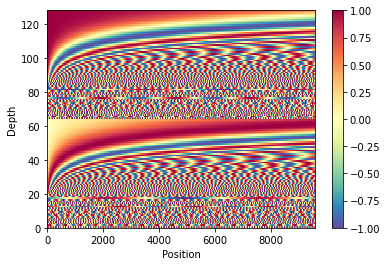

In [60]:
pos_encoding = positional_encoding(length=VOCAB_SIZE, depth=D_MODEL)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='Spectral_r')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

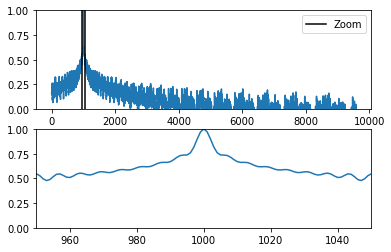

In [28]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])
plt.show()

In [29]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=vocab_size, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [30]:
embed_pt = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)
embed_en = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)
en_emb._keras_mask[0]

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False])>

#### The base attention layer

In [31]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### The cross attention layer

In [32]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [33]:
sample_ca = CrossAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 20, 128)
(64, 20, 128)
(64, 20, 128)


#### The global self attention layer

In [34]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [35]:
sample_gsa = GlobalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 20, 128)
(64, 20, 128)


#### The causal self attention layer

In [36]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [37]:
sample_csa = CausalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 20, 128)
(64, 20, 128)


In [38]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

#### The feed forward network

In [39]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [40]:
sample_ffn = FeedForward(D_MODEL, DFF)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 20, 128)
(64, 20, 128)


#### The encoder layer

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [42]:
sample_encoder_layer = EncoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 20, 128)
(64, 20, 128)


In [43]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1, **kwargs):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [44]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 20)
(64, 20, 128)


#### The decoder layer

In [45]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [46]:
sample_decoder_layer = DecoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 20, 128)
(64, 20, 128)
(64, 20, 128)


In [47]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [48]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 20)
(64, 20, 128)
(64, 20, 128)


#### The Transformer

In [49]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [50]:
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT)

In [51]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 20)
(64, 20)
(64, 20, 9590)


In [52]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 4, 20, 20)


In [53]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1524864   
                                                                 
 decoder_1 (Decoder)         multiple                  1788928   
                                                                 
 dense_14 (Dense)            multiple                  1237110   
                                                                 
Total params: 4,550,902
Trainable params: 4,550,902
Non-trainable params: 0
_________________________________________________________________


### Training

#### Set up the optimizer

In [54]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [55]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

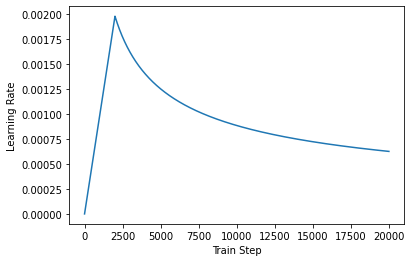

In [56]:
plt.plot(learning_rate(tf.range(20000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [57]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Train the model

In [58]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
%%time
t_tistory = transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/2
63/63 [==============================] - 35s 460ms/step - loss: 9.0640 - masked_accuracy: 2.2549e-04 - val_loss: 8.9871 - val_masked_accuracy: 9.5129e-05
Epoch 2/2
63/63 [==============================] - 30s 469ms/step - loss: 8.8764 - masked_accuracy: 0.0655 - val_loss: 8.7136 - val_masked_accuracy: 0.0969
CPU times: user 1min 39s, sys: 4.34 s, total: 1min 43s
Wall time: 1min 16s


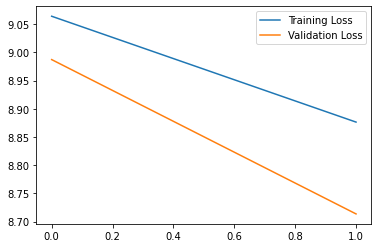

In [ ]:
plt.plot(t_tistory.history["loss"], label="Training Loss")
plt.plot(t_tistory.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = transformer(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('질문 : "{}"'.format(sentence))
  print('답변 : "{}"'.format(predicted_sentence))

  return predicted_sentence

def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

### Test Chat

In [ ]:
%%time
output = predict('취업하기 위해서 열심히 준비하고 있지만, 직장을 구하지 못할까봐 걱정되')

Input: 너는 누구니?
Output: 
CPU times: user 106 ms, sys: 74 µs, total: 106 ms
Wall time: 109 ms


In [ ]:
%%time
output = predict('딸이 나에게 선물을 줬어. 그래서 너무 기뻐')

Input: 너 멍청한 것 같아
Output: 
CPU times: user 47.2 ms, sys: 863 µs, total: 48.1 ms
Wall time: 51.2 ms


In [ ]:
%%time
output = predict('너는 누구니?')

Input: 친구가 괴롭혀서 힘들어
Output: 
CPU times: user 47.6 ms, sys: 963 µs, total: 48.6 ms
Wall time: 48.6 ms


In [ ]:
%%time
output = predict('아무리 생각해도 너는 멍청한 것 같아')

Input: 선물을 받아서 기뻐
Output: 
CPU times: user 48.7 ms, sys: 0 ns, total: 48.7 ms
Wall time: 57.7 ms
